In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import csutils as csu

from jitcode import y, t, jitcode

import sys
# Change path to your location of dynamicswitches
sys.path.append('/Users/luuk/OneDrive/Documents/School/machem2/pmcs/dynamicswitches')
import changingswitches as cs

## Timescales

The functional form for $a$

$$\begin{align}
a(t) &= a(X_t) \\
&= \bar{a} + \Delta a \tanh \left(\kappa(X_t - X_c)\right)
\end{align}$$

This is simply some approximation. More generally, $a(t)$ is found from the ODE $\frac{da}{dt}=G(X, X_t, a)$

* The function $G$ is unknown, but we can force it's limiting case to coincide with $a(t)$ by $G(X, X_t, a) \overset{\text{def}}{=} \delta^{-1} \left(H(X_t) - a\right)$ such that when $\delta \rightarrow 0 \implies a(t) = H(X_t)$, i.e. $a$ changes instantenously according to $H(X_t)$ as was previously assumed

NameError: name 'a' is not defined

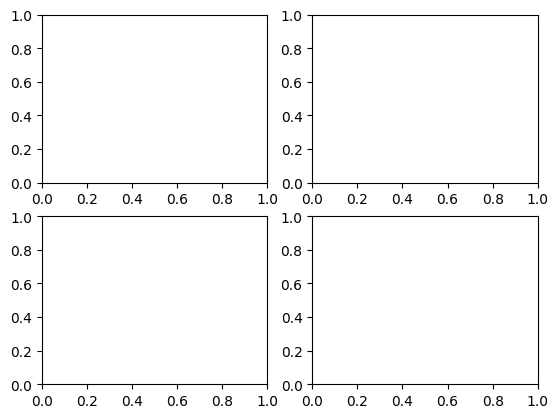

In [3]:
p = dict(b=1., K=1, n=5, ap=0.1, bp=1., Kp=1., m=5)
a = 0.3

# Hill functions
def f(x, a):
    return a +p['b']*x**p['n']/(p['K']**p['n'] + x**p['n'])
def g(x):
    return p['ap']+p['bp']*p['Kp']**p['m']/(p['Kp']**p['m'] + x**p['m'])


# compute static switch
switch= cs.ResponseOneEnzymeXt(a=a, **p)
switchdat = []

switch.setcontpars(0.01,2000)
switch.setstart(0,0,[0.1,0.1])
switch.compute_responsecurve()


kX = 1.6
kappa = 5.
epsilon = 0.05
delta = 0.1

# threshold value used in a(X_T)
Xc = 0.5*(switch.folds[0][0] + switch.folds[1][0])

def F(x, xc):
    return sp.tanh(kappa*(x-xc))
def Fn(x, xc):
    return np.tanh(kappa*(x-xc))

fig, axes = plt.subplots(2,2)

# simulate once for a static, once for a changing switch
for i,da in enumerate([0, 0.3]):
    dxdt = [
        1/epsilon * (f(y(0), y(2)) * (y(1) - y(0)) - g(y(0)) * y(0)),
        kX - y(1) * y(0),
        1/delta*(a + da * F(y(1), Xc) - y(2))
    ]
    
    # jitcdde takes a list of expressions for each dimensions: X and X_t in this case
    y0 = [0,0,0.1] # initial condition X=X_t=0, a=0?
    odesys = jitcode(dxdt)
    odesys.set_integrator('RK45')
    odesys.set_initial_value(y0)

    timeseries = []

    tv = np.arange(odesys.t, odesys.t + 20, 0.01)
    for time in tv: # integrate over time range
        timeseries.append( odesys.integrate(time) )

    timeseries = np.array(timeseries)
    Xv = timeseries[:,0]
    XTv = timeseries[:,1]
    av = timeseries[:,2]
    
    if da > 0: # keep the a values for the changing switch, to use for plotting snapshots of the switch
        av = a + da * Fn(XTv,Xc)

    axes[i,0].plot(XTv,Xv)
    axes[i,1].plot(tv, Xv, label='$X$')
    axes[i,1].plot(tv, av, label='$a$')
    axes[i,1].plot(tv, XTv, label='$X_T$')


# add labels etc
for ax in axes[:,0]: # phaseplanes
    ax.set_xlabel('$X_T$')
    ax.set_ylabel('$X$')
    ax.set_xlim(1,3)
    ax.set_ylim(0,2)

# plot the switch curve for static switch
axes[0,0].plot(switch.xtv, switch.xv, 'k')

# plot snapshots for the changing switch
# use a range of a values in between min and max a attained in the limit cycle
n=6
lowa = np.min(av[-500:])
higha = np.max(av[-500:])

for i,aa in enumerate(np.linspace(lowa,higha,n)):
    switch.a=aa
    switch.compute_responsecurve()
    axes[1,0].plot(switch.xtv, switch.xv, color='k', alpha=i/n)

for ax in axes[:,1]: # time series
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    ax.legend()

axes[0,0].set_title('Static')
axes[1,0].set_title('Changing')
plt.tight_layout()
plt.show()